In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\UsamaAbid\Documents\Personal Projects\Mantel Group\data\Mall_Customers.csv")

c:\Users\UsamaAbid\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.shape

(200, 5)

In [4]:
df.drop(columns=['CustomerID'], inplace=True, axis=1)

In [6]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [7]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def train(input_data, n_max_iterations, width, height):
    σ0 = max(width, height) / 2
    α0 = 0.5
    weights = np.random.random((width, height, input_data.shape[1]))
    λ = n_max_iterations / np.log(σ0)

    # Precompute grid coordinates
    X, Y = np.meshgrid(np.arange(width), np.arange(height), indexing='ij')
    grid = np.stack([X, Y], axis=2)  # shape: (width, height, 2)

    for t in range(n_max_iterations):
        σt = σ0 * np.exp(-t / λ)
        αt = α0 * np.exp(-t / λ)

        for vt in input_data:
            # Find BMU
            diff = weights - vt
            distances = np.sum(diff**2, axis=2)
            bmu_index = np.argmin(distances)
            bmu_coords = np.unravel_index(bmu_index, (width, height))

            # Compute distance of all neurons to BMU
            d_grid = np.sum((grid - bmu_coords)**2, axis=2)  # shape: (width, height)

            # Compute neighborhood influence
            θt = np.exp(-d_grid / (2 * σt**2))  # shape: (width, height)
            θt = θt[..., np.newaxis]  # shape: (width, height, 1) for broadcasting

            # Update weights
            weights += αt * θt * (vt - weights)

    return weights


In [9]:
input_data = np.array(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values, dtype=np.float32)

In [11]:
#Load and fit MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

input_data.shape

(200, 3)

In [12]:
input_data.shape

(200, 3)

In [13]:
som_weights = train(input_data, 5000, 15, 15)
plt.imsave('cutomer.png', som_weights)

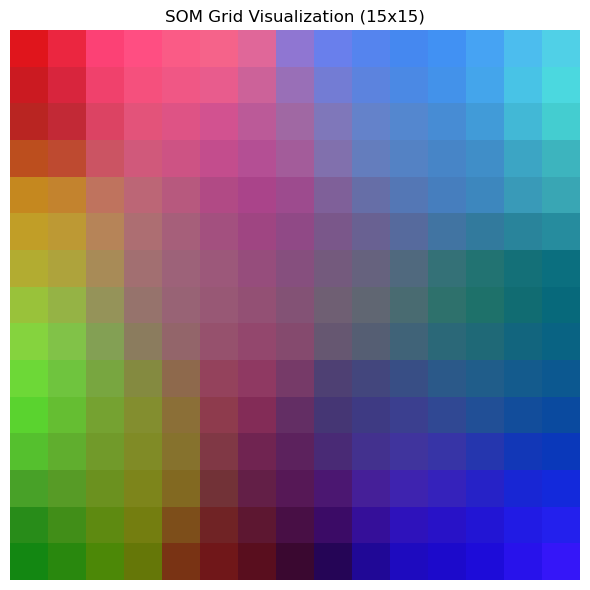

In [14]:
image = som_weights / np.max(som_weights)

# Plot the SOM as an image
plt.figure(figsize=(6, 6))
plt.imshow(image, aspect='auto')
plt.title("SOM Grid Visualization (15x15)")
plt.axis('off')
plt.tight_layout()
plt.show()

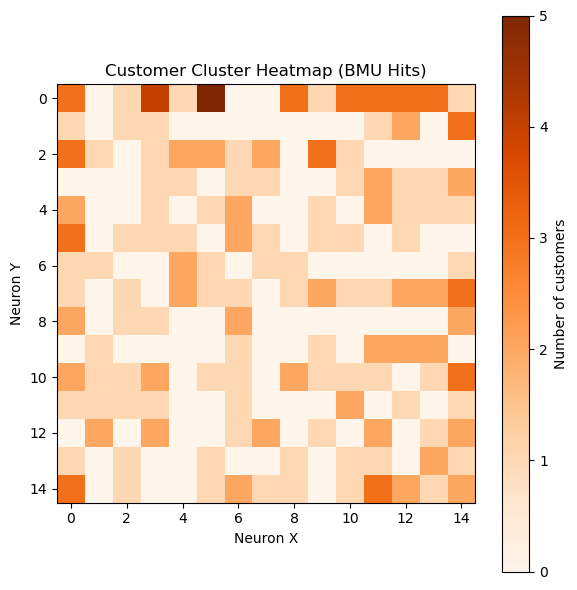

In [15]:
# Function to find BMU for each input vector
def find_bmu(input_vector, som_weights):
    distances = np.linalg.norm(som_weights - input_vector, axis=2)
    return np.unravel_index(np.argmin(distances), distances.shape)

# Create hit map
hit_map = np.zeros((15, 15))

# Count how many times each neuron is the BMU
for vector in input_data:
    bmu_x, bmu_y = find_bmu(vector, som_weights)
    hit_map[bmu_x, bmu_y] += 1

# Plot hit map
plt.figure(figsize=(6, 6))
plt.imshow(hit_map, cmap='Oranges', interpolation='nearest')
plt.colorbar(label='Number of customers')
plt.title('Customer Cluster Heatmap (BMU Hits)')
plt.xlabel('Neuron X')
plt.ylabel('Neuron Y')
plt.tight_layout()
plt.show()

In [16]:
# Apply Kmeans
width, height, features = 15, 15, 3
flattened_weights = som_weights.reshape(-1, features)

In [17]:
flattened_weights.shape

(225, 3)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 2: Apply KMeans to SOM neurons
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(flattened_weights)

c:\Users\UsamaAbid\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


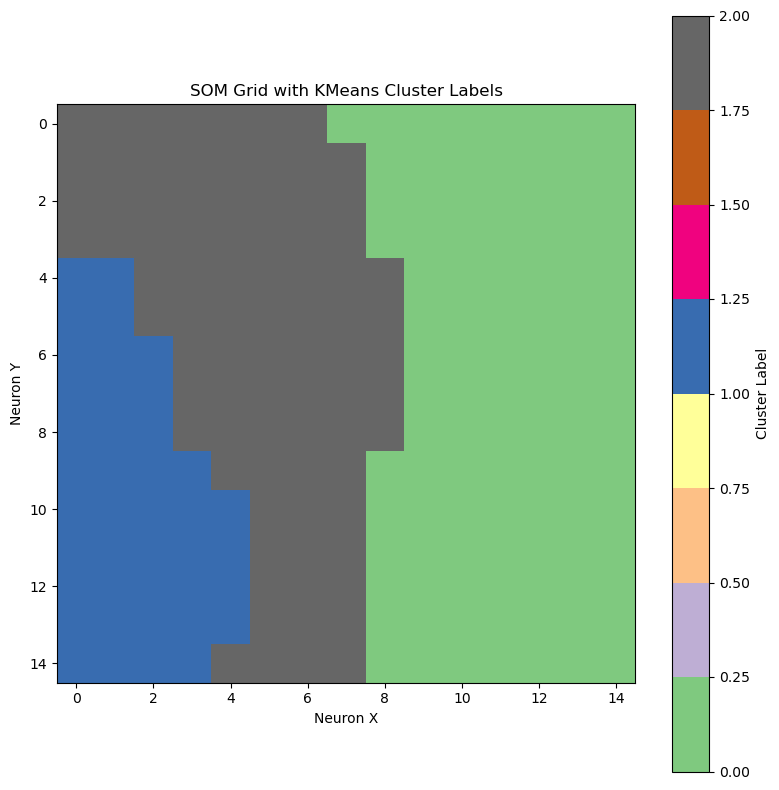

In [20]:
# Step 3: Reshape labels back to SOM grid shape
cluster_map = cluster_labels.reshape(width, height)

# Step 4: Create a BMU hit map
def find_bmu(input_vector, weights):
    distances = np.linalg.norm(weights - input_vector, axis=2)
    return np.unravel_index(np.argmin(distances), distances.shape)

hit_map = np.zeros((width, height))
for vector in input_data:
    bmu_x, bmu_y = find_bmu(vector, som_weights)
    hit_map[bmu_x, bmu_y] += 1

# Step 5: Plot SOM cluster map with KMeans labels
plt.figure(figsize=(8, 8))
plt.imshow(cluster_map, cmap='Accent', interpolation='nearest')
plt.title("SOM Grid with KMeans Cluster Labels")
plt.colorbar(label='Cluster Label')
plt.xlabel("Neuron X")
plt.ylabel("Neuron Y")
plt.tight_layout()
plt.show()

In [21]:
# # Elbow method to find optimal number of clusters
# inertia_values = []
# k_values = range(1, 11)

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(flattened_weights)
#     inertia_values.append(kmeans.inertia_)

# # Plot the elbow curve
# plt.figure(figsize=(8, 5))
# plt.plot(k_values, inertia_values, marker='o')
# plt.title('Elbow Method for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [22]:
cluster_labels

array([2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0])

In [23]:
# Predict function to assign cluster to each input data point
def assign_clusters(data, som_weights, kmeans_model):
    width, height, _ = som_weights.shape
    cluster_indices = []

    for vt in data:
        bmu_idx = np.argmin(np.sum((som_weights - vt) ** 2, axis=2))
        bmu_coords = np.unravel_index(bmu_idx, (width, height))
        flat_bmu = bmu_coords[0] * height + bmu_coords[1]
        cluster_label = kmeans_model.labels_[flat_bmu]
        cluster_indices.append(cluster_label)

    return np.array(cluster_indices)

cluster_assignments = assign_clusters(input_data, som_weights, kmeans)

In [24]:
cluster_assignments

array([0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0,
       0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0])

In [25]:
# Append cluster labels to scaled data
scaled_with_clusters = np.hstack((input_data, cluster_assignments.reshape(-1, 1)))

# Inverse transform the features (not the cluster labels)
input_data_unscaled = scaler.inverse_transform(scaled_with_clusters[:, :-1])

# Create final DataFrame with original values and cluster labels
final_df = pd.DataFrame(input_data_unscaled, columns=["Age", "Annual Income (k$)", "Spending Score (1-100)"])
final_df["Cluster"] = scaled_with_clusters[:, -1].astype(int)


In [26]:
final_df

,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,19.000000,15.000000,39.000000,0
1,21.000000,15.000000,80.999999,0
2,20.000000,16.000000,6.000000,2
3,23.000000,16.000000,77.000000,0
4,30.999999,17.000001,40.000000,0
...,...,...,...,...
195,34.999999,120.000005,78.999999,0
196,45.000000,126.000005,27.999999,1
197,32.000000,126.000005,74.000002,0
198,32.000000,137.000007,18.000001,1


In [32]:
final_df.groupby('Cluster')[['Age',	'Annual Income (k$)',	'Spending Score (1-100)']].describe()

Age                                                               \
        count       mean        std   min        25%        50%        75%   
Cluster                                                                      
0        99.0  28.555555   6.202735  18.0  23.000000  29.000001  32.000000   
1        33.0  41.212121  10.930912  19.0  34.000001  42.000001  47.000001   
2        68.0  52.691176  10.604501  20.0  47.000001  50.500000  60.749999   

                   Annual Income (k$)             ...                         \
               max              count       mean  ...        75%         max   
Cluster                                           ...                          
0        39.999999               99.0  60.727273  ...  78.000001  137.000007   
1        59.000000               33.0  89.030305  ...  98.000000  137.000007   
2        69.999998               68.0  46.499999  ...  60.000000   79.000000   

        Spending Score (1-100)                                              \
                         count       mean        std        min        25%   
Cluster                                                                      
0                         99.0  68.757576  18.202428  29.000002  53.999999   
1                         33.0  16.212121   9.486035   1.000000  10.000000   
2                         68.0  39.676471  16.211698   3.000000  34.249999   

                                          
               50%        75%        max  
Cluster                                   
0        73.000002  84.000000  99.000002  
1        15.000001  22.000001  39.000000  
2        45.500000  51.000001  60.000002  

[3 rows x 24 columns]

In [ ]:
''